# Imports

In [13]:
# Linear Algebra, Plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading, Computer Vision Libraries
import os
import glob
import cv2 # pip install opencv-python-headless
from PIL import Image

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import normalize

# PyTorch Deep Learning Imports
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Modelling
import optuna
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [3]:
# Import Images

input_size = 64 # Resize to 64x64
yes = []
no = []

for gl in glob.iglob('./Data/yes/*'):
    image = cv2.imread(gl)
    image=Image.fromarray(image,'RGB')
    image=image.resize((input_size, input_size))
    yes.append((image, 1))
for gl in glob.iglob('./Data/no/*'):
    image = cv2.imread(gl)
    image=Image.fromarray(image,'RGB')
    image=image.resize((input_size, input_size))
    no.append((image, 0))

data = yes + no

The "1" label is for a tumor present, and "0" is for when a tumor is not present

# Preprocessing

Let's view the first few images for tumor and no tumor.

In [4]:
def display_images(data, label_to_view, num_images=5):
    filtered_data = [item for item in data if item[1] == label_to_view]
    filtered_data = filtered_data[:num_images]
    
    fig, axes = plt.subplots(1, len(filtered_data), figsize=(15, 5)) 
    
    for ax, (image, label) in zip(axes, filtered_data):
        ax.imshow(image)
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

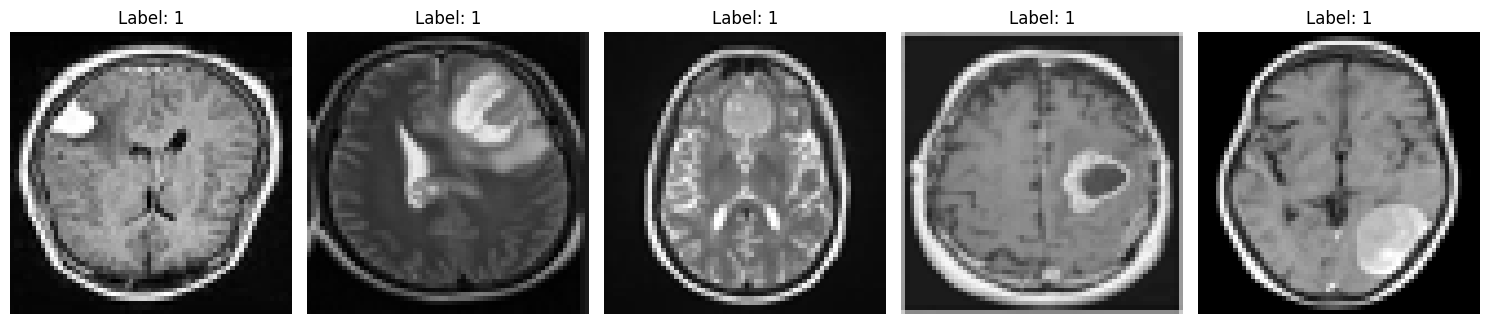

In [5]:
display_images(data, label_to_view=1, num_images=5) 

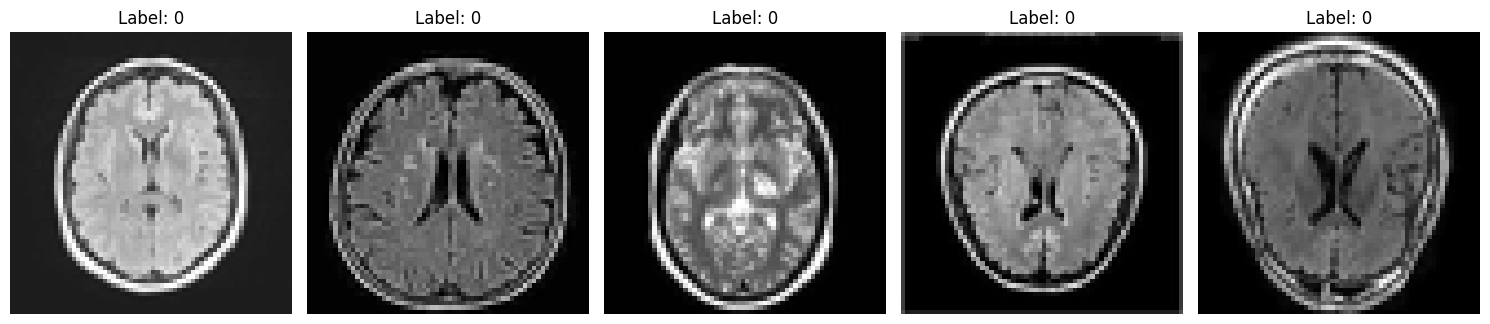

In [6]:
display_images(data, label_to_view=0, num_images=5) 

Let us convert these into numpy arrays of size 64x64 for modelling purposes

In [7]:
images = np.array([np.array(i[0]) for i in data])  
labels = np.array([i[1] for i in data])

print(images.shape)
print(labels.shape)

(3000, 64, 64, 3)
(3000,)


Let us split this into training, testing, and validation sets. For this split, we will use a train-test-val split ratio of 70-15-15. We will also stratify by the 'y' labels to ensure an even split amongst our classes

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, stratify=labels, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, shuffle=True, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape} \n")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape} \n")

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (2100, 64, 64, 3)
y_train shape: (2100,) 

X_test shape: (450, 64, 64, 3)
y_test shape: (450,) 

X_val shape: (450, 64, 64, 3)
y_val shape: (450,)


Count the number of different labels in each set to ensure that they are split evenly

In [9]:
train_label_counts = np.bincount(y_train)
print(f"Training set: {train_label_counts[0]} 0s, {train_label_counts[1]} 1s")

val_label_counts = np.bincount(y_val)
print(f"Validation set: {val_label_counts[0]} 0s, {val_label_counts[1]} 1s")

test_label_counts = np.bincount(y_test)
print(f"Test set: {test_label_counts[0]} 0s, {test_label_counts[1]} 1s")

Training set: 1050 0s, 1050 1s
Validation set: 225 0s, 225 1s
Test set: 225 0s, 225 1s


As a quick sanity check, let us view our images again to see if we split it correctly by label

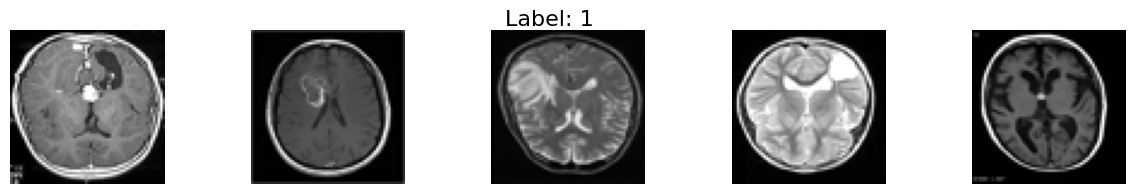

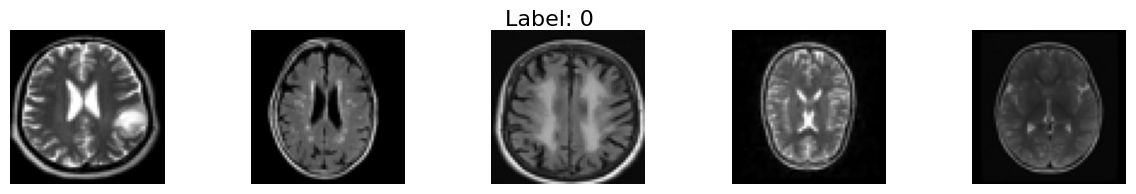

In [10]:
label_0_images = [X_train[i] for i in range(len(y_train)) if y_train[i] == 0]
label_1_images = [X_train[i] for i in range(len(y_train)) if y_train[i] == 1]

def display_images_by_label(images, label, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))
    fig.suptitle(f"Label: {label}", fontsize=16)
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')
    plt.show()

display_images_by_label(label_1_images, label=1, num_images=5)
display_images_by_label(label_0_images, label=0, num_images=5)

# PCA Reconstruction Classification

## Flattening and normalizing the data:

In [11]:
def preprocess_images_pca(images):
    images = np.array(images)
    images_flat = images.reshape(images.shape[0], -1)
    images_normalized = (images_flat - images_flat.mean(axis=0)) / images_flat.std(axis=0)
    return images_normalized

## Fitting PCA

In [14]:
label_0_normalized = preprocess_images_pca(label_0_images)
mean_0_image = np.mean(label_0_normalized, axis=0)
A = label_0_normalized - mean_0_image

U, S, Vt = np.linalg.svd(A, full_matrices=False)
eigvals = S**2
V = Vt.T  

U = normalize(U, norm='l2', axis=0)

In [15]:
def compute_reconstruction_errors(X_normalized):
    reconstruction_error = []
    
    for z in X_normalized:
        c = V.T.dot(z - mean_0_image)  
        Zhat = V.dot(c) + mean_0_image
        reconstruction_error.append(np.linalg.norm(z - Zhat))
    return reconstruction_error

In [16]:
def pca_classification(X, y, threshold):
    X_normalized = preprocess_images_pca(X)
    reconstruction_error = compute_reconstruction_errors(X_normalized)
        
    X_labels = np.array([1 if error > threshold else 0 for error in reconstruction_error])
    
    accuracy = (np.sum(X_labels == y) / len(X_labels)) * 100
    return accuracy

## Finding the best threshold

Testing PCA classification on training set to find an initial threshold by taking the mean of max_non_tumor_error and min_tumor_error:

In [17]:
label_1_normalized = preprocess_images_pca(label_1_images)

error_non_tumor = compute_reconstruction_errors(label_0_normalized)
error_tumor = compute_reconstruction_errors(label_1_normalized)

max_non_tumor_error = max(error_non_tumor)
min_tumor_error = min(error_tumor)
initial_threshold = (max_non_tumor_error + min_tumor_error) / 2
print(f"Initial Threshold: {initial_threshold}")

Initial Threshold: 9.512154462209567


Adjusting the initial threshold till we find the best one that maximizes accuracy for the validation set:

In [20]:
best_threshold = None
best_val_accuracy = 0
thresholds = np.arange(initial_threshold - 5, initial_threshold + 15, 2.5)

for threshold in thresholds:
    print(f"Testing Threshold: {threshold:.2f}")
        
    train_accuracy = pca_classification(X_train, y_train, threshold)
    print(f"Training Accuracy: {train_accuracy:.2f}%")
        
    val_accuracy = pca_classification(X_val, y_val, threshold)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
        
    print('-----------------------------')
        
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_threshold = threshold
        best_train_accuracy = train_accuracy

print('Best Threshold:', best_threshold) 
print('Training Accuracy:', best_train_accuracy)
print('Best Validation Accuracy:', best_val_accuracy)


Testing Threshold: 4.51
Training Accuracy: 78.57%
Validation Accuracy: 61.33%
-----------------------------
Testing Threshold: 7.01
Training Accuracy: 90.67%
Validation Accuracy: 74.67%
-----------------------------
Testing Threshold: 9.51
Training Accuracy: 95.76%
Validation Accuracy: 80.67%
-----------------------------
Testing Threshold: 12.01
Training Accuracy: 97.52%
Validation Accuracy: 85.78%
-----------------------------
Testing Threshold: 14.51
Training Accuracy: 98.67%
Validation Accuracy: 89.56%
-----------------------------
Testing Threshold: 17.01
Training Accuracy: 99.67%
Validation Accuracy: 94.00%
-----------------------------
Testing Threshold: 19.51
Training Accuracy: 99.67%
Validation Accuracy: 94.67%
-----------------------------
Testing Threshold: 22.01
Training Accuracy: 98.76%
Validation Accuracy: 94.22%
-----------------------------
Best Threshold: 19.512154462209566
Training Accuracy: 99.66666666666667
Best Validation Accuracy: 94.66666666666667


The best threshold is around 19.5. We can use this as the final threshold for the testing set.

## Evaluate on Test Set

In [21]:
print(f"Test Accuracy: {pca_classification(X_test, y_test, best_threshold):.4f}")

Test Accuracy: 93.1111


We can better visualize our model with a confusion matrix

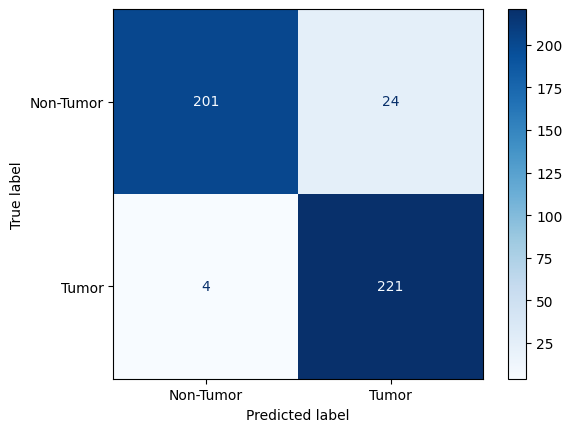

In [23]:
X_normalized = preprocess_images_pca(X_test)
reconstruction_error = compute_reconstruction_errors(X_normalized)     
X_labels = np.array([1 if error > threshold else 0 for error in reconstruction_error])

cm = confusion_matrix(y_test, X_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Tumor", "Tumor"])
disp.plot(cmap="Blues", values_format='d');

The PCA model performs decently well, with an accuracy of 93.11, predicting 28 out of 450 images incorrectly.

# Supervised Convolutional Neural Network (CNN) Classification

## Put the data into tensors and define our CNN

In [11]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Convert to float and add dimension
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.normalize = nn.BatchNorm2d(3)  
        self.conv = nn.Conv2d(3, 32, kernel_size=3, padding='same')  
        self.pool = nn.MaxPool2d(2) 
        self.flatten = nn.Flatten() 
        self.fc = nn.Linear(32 * (input_size // 2) * (input_size // 2), 1) 
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        x = self.normalize(x)
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

## Train our CNN

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  
        loss = criterion(outputs, labels)  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_loader_tqdm.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})

    train_losses.append(running_loss / len(train_loader))  
    train_accuracies.append(100 * correct_train / total_train)  

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader)) 
    val_accuracies.append(100 * correct_val / total_val) 

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

Epoch 1/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 42.39it/s, Loss=0.5087]


Epoch 1/50, Train Loss: 0.5087, Train Accuracy: 74.05%, Val Loss: 0.3961, Val Accuracy: 82.00%


Epoch 2/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 43.52it/s, Loss=0.3876]


Epoch 2/50, Train Loss: 0.3876, Train Accuracy: 82.14%, Val Loss: 0.3392, Val Accuracy: 84.89%


Epoch 3/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 43.21it/s, Loss=0.3329]


Epoch 3/50, Train Loss: 0.3329, Train Accuracy: 85.67%, Val Loss: 0.3484, Val Accuracy: 86.89%


Epoch 4/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 43.73it/s, Loss=0.2857]


Epoch 4/50, Train Loss: 0.2857, Train Accuracy: 88.57%, Val Loss: 0.2856, Val Accuracy: 89.33%


Epoch 5/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 43.56it/s, Loss=0.2602]


Epoch 5/50, Train Loss: 0.2602, Train Accuracy: 91.00%, Val Loss: 0.2503, Val Accuracy: 90.44%


Epoch 6/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 41.72it/s, Loss=0.2263]


Epoch 6/50, Train Loss: 0.2263, Train Accuracy: 92.67%, Val Loss: 0.2450, Val Accuracy: 90.89%


Epoch 7/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 38.63it/s, Loss=0.1945]


Epoch 7/50, Train Loss: 0.1945, Train Accuracy: 94.24%, Val Loss: 0.2098, Val Accuracy: 91.78%


Epoch 8/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 42.82it/s, Loss=0.1734]


Epoch 8/50, Train Loss: 0.1734, Train Accuracy: 95.62%, Val Loss: 0.1950, Val Accuracy: 94.00%


Epoch 9/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 43.37it/s, Loss=0.1572]


Epoch 9/50, Train Loss: 0.1572, Train Accuracy: 95.86%, Val Loss: 0.2079, Val Accuracy: 93.56%


Epoch 10/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.57it/s, Loss=0.1413]


Epoch 10/50, Train Loss: 0.1413, Train Accuracy: 96.81%, Val Loss: 0.1630, Val Accuracy: 94.67%


Epoch 11/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.79it/s, Loss=0.1271]


Epoch 11/50, Train Loss: 0.1271, Train Accuracy: 97.24%, Val Loss: 0.1677, Val Accuracy: 94.89%


Epoch 12/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.11it/s, Loss=0.1120]


Epoch 12/50, Train Loss: 0.1120, Train Accuracy: 98.05%, Val Loss: 0.1784, Val Accuracy: 93.33%


Epoch 13/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.64it/s, Loss=0.1030]


Epoch 13/50, Train Loss: 0.1030, Train Accuracy: 98.19%, Val Loss: 0.1462, Val Accuracy: 94.89%


Epoch 14/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.84it/s, Loss=0.0937]


Epoch 14/50, Train Loss: 0.0937, Train Accuracy: 98.67%, Val Loss: 0.1317, Val Accuracy: 96.44%


Epoch 15/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.70it/s, Loss=0.0826]


Epoch 15/50, Train Loss: 0.0826, Train Accuracy: 99.00%, Val Loss: 0.1245, Val Accuracy: 96.00%


Epoch 16/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.67it/s, Loss=0.0755]


Epoch 16/50, Train Loss: 0.0755, Train Accuracy: 99.00%, Val Loss: 0.1175, Val Accuracy: 96.89%


Epoch 17/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 37.34it/s, Loss=0.0712]


Epoch 17/50, Train Loss: 0.0712, Train Accuracy: 99.05%, Val Loss: 0.1163, Val Accuracy: 97.11%


Epoch 18/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.99it/s, Loss=0.0668]


Epoch 18/50, Train Loss: 0.0668, Train Accuracy: 99.00%, Val Loss: 0.1073, Val Accuracy: 96.00%


Epoch 19/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 44.09it/s, Loss=0.0575]


Epoch 19/50, Train Loss: 0.0575, Train Accuracy: 99.33%, Val Loss: 0.1010, Val Accuracy: 96.67%


Epoch 20/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.41it/s, Loss=0.0552]


Epoch 20/50, Train Loss: 0.0552, Train Accuracy: 99.43%, Val Loss: 0.0950, Val Accuracy: 97.33%


Epoch 21/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.88it/s, Loss=0.0512]


Epoch 21/50, Train Loss: 0.0512, Train Accuracy: 99.29%, Val Loss: 0.0909, Val Accuracy: 96.89%


Epoch 22/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.77it/s, Loss=0.0487]


Epoch 22/50, Train Loss: 0.0487, Train Accuracy: 99.52%, Val Loss: 0.0983, Val Accuracy: 97.11%


Epoch 23/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.50it/s, Loss=0.0446]


Epoch 23/50, Train Loss: 0.0446, Train Accuracy: 99.43%, Val Loss: 0.0857, Val Accuracy: 97.33%


Epoch 24/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.65it/s, Loss=0.0409]


Epoch 24/50, Train Loss: 0.0409, Train Accuracy: 99.62%, Val Loss: 0.0805, Val Accuracy: 97.78%


Epoch 25/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.82it/s, Loss=0.0350]


Epoch 25/50, Train Loss: 0.0350, Train Accuracy: 99.57%, Val Loss: 0.0936, Val Accuracy: 96.89%


Epoch 26/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 44.37it/s, Loss=0.0341]


Epoch 26/50, Train Loss: 0.0341, Train Accuracy: 99.67%, Val Loss: 0.0796, Val Accuracy: 97.78%


Epoch 27/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.79it/s, Loss=0.0308]


Epoch 27/50, Train Loss: 0.0308, Train Accuracy: 99.71%, Val Loss: 0.0763, Val Accuracy: 97.78%


Epoch 28/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.68it/s, Loss=0.0288]


Epoch 28/50, Train Loss: 0.0288, Train Accuracy: 99.67%, Val Loss: 0.0752, Val Accuracy: 98.00%


Epoch 29/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.16it/s, Loss=0.0263]


Epoch 29/50, Train Loss: 0.0263, Train Accuracy: 99.71%, Val Loss: 0.0720, Val Accuracy: 97.78%


Epoch 30/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.83it/s, Loss=0.0267]


Epoch 30/50, Train Loss: 0.0267, Train Accuracy: 99.76%, Val Loss: 0.0739, Val Accuracy: 97.78%


Epoch 31/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.44it/s, Loss=0.0227]


Epoch 31/50, Train Loss: 0.0227, Train Accuracy: 99.76%, Val Loss: 0.0694, Val Accuracy: 98.00%


Epoch 32/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.92it/s, Loss=0.0215]


Epoch 32/50, Train Loss: 0.0215, Train Accuracy: 99.86%, Val Loss: 0.0733, Val Accuracy: 97.33%


Epoch 33/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.85it/s, Loss=0.0196]


Epoch 33/50, Train Loss: 0.0196, Train Accuracy: 99.86%, Val Loss: 0.0816, Val Accuracy: 97.33%


Epoch 34/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.12it/s, Loss=0.0190]


Epoch 34/50, Train Loss: 0.0190, Train Accuracy: 99.81%, Val Loss: 0.0715, Val Accuracy: 97.33%


Epoch 35/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.22it/s, Loss=0.0168]


Epoch 35/50, Train Loss: 0.0168, Train Accuracy: 99.86%, Val Loss: 0.0629, Val Accuracy: 97.78%


Epoch 36/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.29it/s, Loss=0.0157]


Epoch 36/50, Train Loss: 0.0157, Train Accuracy: 99.95%, Val Loss: 0.0661, Val Accuracy: 97.78%


Epoch 37/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.11it/s, Loss=0.0154]


Epoch 37/50, Train Loss: 0.0154, Train Accuracy: 99.86%, Val Loss: 0.0664, Val Accuracy: 98.00%


Epoch 38/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.60it/s, Loss=0.0138]


Epoch 38/50, Train Loss: 0.0138, Train Accuracy: 99.90%, Val Loss: 0.0699, Val Accuracy: 97.56%


Epoch 39/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.40it/s, Loss=0.0124]


Epoch 39/50, Train Loss: 0.0124, Train Accuracy: 99.95%, Val Loss: 0.0703, Val Accuracy: 97.33%


Epoch 40/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.91it/s, Loss=0.0117]


Epoch 40/50, Train Loss: 0.0117, Train Accuracy: 100.00%, Val Loss: 0.0615, Val Accuracy: 98.00%


Epoch 41/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 41.73it/s, Loss=0.0107]


Epoch 41/50, Train Loss: 0.0107, Train Accuracy: 100.00%, Val Loss: 0.0669, Val Accuracy: 97.56%


Epoch 42/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.11it/s, Loss=0.0101]


Epoch 42/50, Train Loss: 0.0101, Train Accuracy: 100.00%, Val Loss: 0.0626, Val Accuracy: 97.78%


Epoch 43/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.71it/s, Loss=0.0093]


Epoch 43/50, Train Loss: 0.0093, Train Accuracy: 100.00%, Val Loss: 0.0684, Val Accuracy: 98.00%


Epoch 44/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.10it/s, Loss=0.0088]


Epoch 44/50, Train Loss: 0.0088, Train Accuracy: 100.00%, Val Loss: 0.0667, Val Accuracy: 97.33%


Epoch 45/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.18it/s, Loss=0.0083]


Epoch 45/50, Train Loss: 0.0083, Train Accuracy: 100.00%, Val Loss: 0.0713, Val Accuracy: 97.56%


Epoch 46/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.95it/s, Loss=0.0075]


Epoch 46/50, Train Loss: 0.0075, Train Accuracy: 100.00%, Val Loss: 0.0669, Val Accuracy: 97.56%


Epoch 47/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 44.34it/s, Loss=0.0070]


Epoch 47/50, Train Loss: 0.0070, Train Accuracy: 100.00%, Val Loss: 0.0661, Val Accuracy: 98.00%


Epoch 48/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.65it/s, Loss=0.0076]


Epoch 48/50, Train Loss: 0.0076, Train Accuracy: 100.00%, Val Loss: 0.0608, Val Accuracy: 98.22%


Epoch 49/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.49it/s, Loss=0.0063]


Epoch 49/50, Train Loss: 0.0063, Train Accuracy: 100.00%, Val Loss: 0.0648, Val Accuracy: 97.78%


Epoch 50/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.60it/s, Loss=0.0060]
                                                                                

Epoch 50/50, Train Loss: 0.0060, Train Accuracy: 100.00%, Val Loss: 0.0675, Val Accuracy: 97.78%


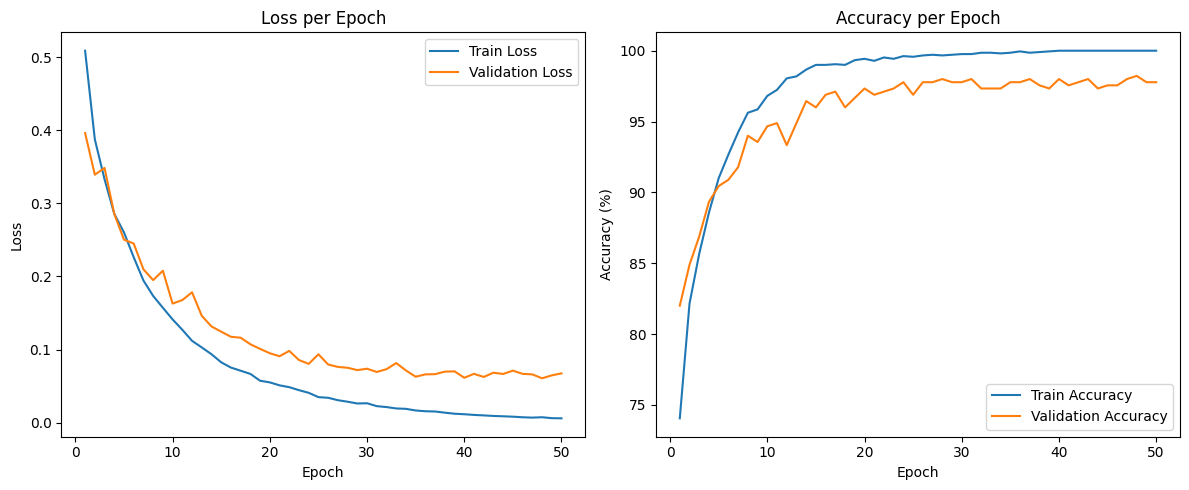

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(range(1, epochs + 1), train_losses, label="Train Loss")
axs[0].plot(range(1, epochs + 1), val_losses, label="Validation Loss")
axs[0].set_title("Loss per Epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
axs[1].plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
axs[1].set_title("Accuracy per Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")
axs[1].legend()

plt.tight_layout()
plt.show()

## Evaluate on Test Set

In [20]:
all_labels = []
all_predictions = []

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float() 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
precision = precision_score(all_labels, all_predictions, average='binary')
recall = recall_score(all_labels, all_predictions, average='binary')
f1 = f1_score(all_labels, all_predictions, average='binary')

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")
print(f"Precision: {100 * precision:.2f}%")
print(f"Recall: {100 * recall:.2f}%")
print(f"F1 Score: {100 * f1:.2f}%")        

Test Loss: 0.1904
Test Accuracy: 96.00%
Precision: 96.41%
Recall: 95.56%
F1 Score: 95.98%


Our trained CNN seems to perform extraordinarily well on the test set, achieving an f1 score above 95%. 

## Generate a confusion matrix to better visualize our model predictions on the test set

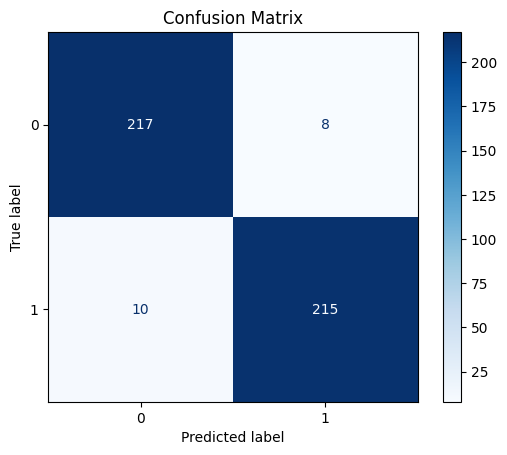

In [21]:
cm = confusion_matrix(all_labels, all_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Masked Autoencoder (MAE) + Anomaly Detection Classification

## Define MAE Structure

In [22]:
class Encoder(nn.Module):
    def __init__(self, img_channels=3, latent_dim=16):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, 32, kernel_size=3, stride=2, padding=1)  # Downsample to 32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)           # Downsample to 16x16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)          # Downsample to 8x8
        self.fc = nn.Linear(128 * 8 * 8, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 128*8*8)
        x = self.fc(x)             # Output: (batch_size, latent_dim)
        return x

class Decoder(nn.Module):
    def __init__(self, img_channels=3, latent_dim=16):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)  # Upsample to 16x16
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)   # Upsample to 32x32
        self.deconv3 = nn.ConvTranspose2d(32, img_channels, kernel_size=3, stride=2, padding=1, output_padding=1)  # Upsample to 64x64

    def forward(self, z):
        x = F.relu(self.fc(z))      # Output: (batch_size, 128*8*8)
        x = x.view(x.size(0), 128, 8, 8)  # Reshape to (batch_size, 128, 8, 8)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))  # Output: (batch_size, img_channels, 64, 64)
        return x

class MAE(nn.Module):
    def __init__(self, img_channels=3, latent_dim=16):
        super(MAE, self).__init__()
        self.encoder = Encoder(img_channels, latent_dim)
        self.decoder = Decoder(img_channels, latent_dim)

    def mask_input(self, x, mask_ratio=0.25):
        mask = torch.rand(x.shape, device=x.device) > mask_ratio
        x_masked = x * mask
        return x_masked, mask

    def forward(self, x, mask_ratio=0.25):
        x_masked, mask = self.mask_input(x, mask_ratio)
        z = self.encoder(x_masked)
        reconstructed = self.decoder(z)
        return reconstructed, mask

def mae_loss_function(reconstructed, original, mask):
    masked_original = original * mask
    reconstruction_loss = F.mse_loss(reconstructed, masked_original, reduction='mean')
    return reconstruction_loss

## Train with normal samples

In [23]:
normal_indices = np.where(y_train == 0)[0]
X_train_normal = X_train[normal_indices]
y_train_normal = y_train[normal_indices]

X_train_normal = torch.tensor(X_train_normal / 255.0, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_normal = torch.tensor(y_train_normal, dtype=torch.float32)

train_dataset = TensorDataset(X_train_normal)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


X_val_data = torch.tensor(X_val / 255.0, dtype=torch.float32).permute(0, 3, 1, 2)
y_val_data = torch.tensor(y_val, dtype=torch.float32)

val_dataset = TensorDataset(X_val_data, y_val_data)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


X_test_data = torch.tensor(X_test / 255.0, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_data = torch.tensor(X_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_data, y_test_data)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mae = MAE(img_channels=3, latent_dim=16).to(device)
optimizer = optim.Adam(mae.parameters(), lr=1e-3)

num_epochs = 10
mask_ratio = 0.25

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mae.train()
    total_train_loss = 0

    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

        for batch in tepoch:
            x = batch[0].to(device)
            optimizer.zero_grad()

            reconstructed, mask = mae(x, mask_ratio)

            loss = mae_loss_function(reconstructed, x, mask)
            loss.backward()

            optimizer.step()

            total_train_loss += loss.item()
            tepoch.set_postfix(train_loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    mae.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device)
            val_reconstructed, val_mask = mae(val_x, mask_ratio)
            val_loss = mae_loss_function(val_reconstructed, val_x, val_mask)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("Training completed!")

Epoch 1/10: 100%|█████████| 33/33 [00:01<00:00, 20.52batch/s, train_loss=0.0399]


Epoch 1/10, Train Loss: 0.0750, Val Loss: 0.0528


Epoch 2/10: 100%|█████████| 33/33 [00:01<00:00, 21.75batch/s, train_loss=0.0345]


Epoch 2/10, Train Loss: 0.0389, Val Loss: 0.0475


Epoch 3/10: 100%|██████████| 33/33 [00:01<00:00, 21.71batch/s, train_loss=0.034]


Epoch 3/10, Train Loss: 0.0370, Val Loss: 0.0467


Epoch 4/10: 100%|██████████| 33/33 [00:01<00:00, 21.05batch/s, train_loss=0.033]


Epoch 4/10, Train Loss: 0.0361, Val Loss: 0.0455


Epoch 5/10: 100%|█████████| 33/33 [00:01<00:00, 20.24batch/s, train_loss=0.0321]


Epoch 5/10, Train Loss: 0.0349, Val Loss: 0.0445


Epoch 6/10: 100%|█████████| 33/33 [00:01<00:00, 20.66batch/s, train_loss=0.0314]


Epoch 6/10, Train Loss: 0.0341, Val Loss: 0.0438


Epoch 7/10: 100%|█████████| 33/33 [00:01<00:00, 20.33batch/s, train_loss=0.0307]


Epoch 7/10, Train Loss: 0.0334, Val Loss: 0.0431


Epoch 8/10: 100%|███████████| 33/33 [00:01<00:00, 21.55batch/s, train_loss=0.03]


Epoch 8/10, Train Loss: 0.0328, Val Loss: 0.0427


Epoch 9/10: 100%|█████████| 33/33 [00:01<00:00, 21.37batch/s, train_loss=0.0297]


Epoch 9/10, Train Loss: 0.0325, Val Loss: 0.0424


Epoch 10/10: 100%|████████| 33/33 [00:01<00:00, 20.84batch/s, train_loss=0.0297]


Epoch 10/10, Train Loss: 0.0322, Val Loss: 0.0420
Training completed!


Let us visualize the progression of training loss and validation loss as the number of epochs increase. 

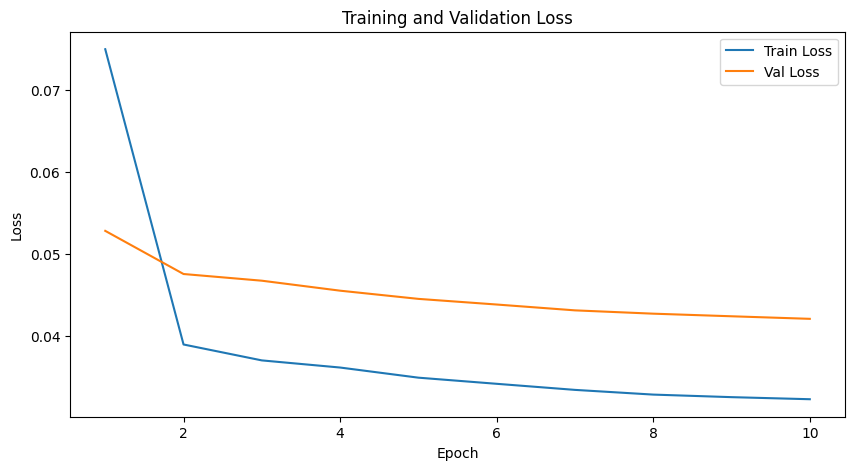

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Now we will extract latent variables from the training, testing, and validation sets. We use the encoder head of the MAE to accomplish this. 

In [26]:
def extract_latent_features(mae, data_loader, device):
    mae.eval()
    latent_features = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Extracting latent features'):
            x = batch[0].to(device)
            latent = mae.encoder(x)
            latent_features.append(latent.cpu())

    latent_features = torch.cat(latent_features, dim=0)
    return latent_features.numpy()

train_latent_normal = extract_latent_features(mae, train_loader, device)
val_latent = extract_latent_features(mae, val_loader, device)
test_latent = extract_latent_features(mae, test_loader, device)

Extracting latent features: 100%|███████████████| 15/15 [00:00<00:00, 48.10it/s]


## Anomaly (Tumor) Detection using MAE extracted features

In [27]:
train_latent_normal.shape

(1050, 16)

We will use Bayesian Optimization

In [28]:
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 5, 300)  
    leaf_size = trial.suggest_int('leaf_size', 5, 100) 
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'chebyshev', 'minkowski'])  

    lof = LocalOutlierFactor(n_neighbors=n_neighbors, leaf_size=leaf_size, metric=metric, novelty=True)
    lof.fit(train_latent_normal)

    val_predictions = lof.predict(val_latent)
    val_true_labels = np.where(y_val == 0, 1, -1)

    f1 = f1_score(val_true_labels, val_predictions, pos_label=1, average='binary')

    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

[I 2024-12-04 17:19:24,152] A new study created in memory with name: no-name-bc31b67d-bbe4-456f-80d6-25c5ce09b7a8
[I 2024-12-04 17:19:24,207] Trial 0 finished with value: 0.6567164179104478 and parameters: {'n_neighbors': 167, 'leaf_size': 75, 'metric': 'chebyshev'}. Best is trial 0 with value: 0.6567164179104478.
[I 2024-12-04 17:19:24,254] Trial 1 finished with value: 0.6666666666666666 and parameters: {'n_neighbors': 164, 'leaf_size': 30, 'metric': 'euclidean'}. Best is trial 1 with value: 0.6666666666666666.
[I 2024-12-04 17:19:24,287] Trial 2 finished with value: 0.6696428571428572 and parameters: {'n_neighbors': 24, 'leaf_size': 14, 'metric': 'minkowski'}. Best is trial 2 with value: 0.6696428571428572.
[I 2024-12-04 17:19:24,346] Trial 3 finished with value: 0.6547085201793722 and parameters: {'n_neighbors': 176, 'leaf_size': 61, 'metric': 'chebyshev'}. Best is trial 2 with value: 0.6696428571428572.
[I 2024-12-04 17:19:24,386] Trial 4 finished with value: 0.6686478454680536 and

Best Hyperparameters: {'n_neighbors': 7, 'leaf_size': 53, 'metric': 'euclidean'}


Evaluate on the testing set

In [29]:
best_lof = LocalOutlierFactor(n_neighbors=best_params['n_neighbors'], 
                              leaf_size=best_params['leaf_size'], 
                              metric=best_params['metric'], 
                              novelty=True)

best_lof.fit(train_latent_normal)

test_predictions = best_lof.predict(test_latent)
test_true_labels = np.where(y_test == 0, 1, -1)

test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_precision = precision_score(test_true_labels, test_predictions, pos_label=1, average='binary')
test_recall = recall_score(test_true_labels, test_predictions, pos_label=1, average='binary')
test_f1 = f1_score(test_true_labels, test_predictions, pos_label=1, average='binary')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.5911
Test Precision: 0.5594
Test Recall: 0.8578
Test F1 Score: 0.6772


Our LocalOutlierFactor trained on features extracted by the Masked Autoencoder do not seem to work well. We only achieve slighly above 65% f1 score, which is better than random guessing but worse than our CNN. This may be due to the masked autoencoder being much more complex than a CNN and thus requiring more data samples, or due to the nature of unsupervised learning being generally less effective than supervised methods.

In [39]:
np.unique(test_true_labels,return_counts=True)

(array([-1,  1]), array([225, 225]))

In [40]:
np.unique(test_predictions,return_counts=True)

(array([-1,  1]), array([105, 345]))

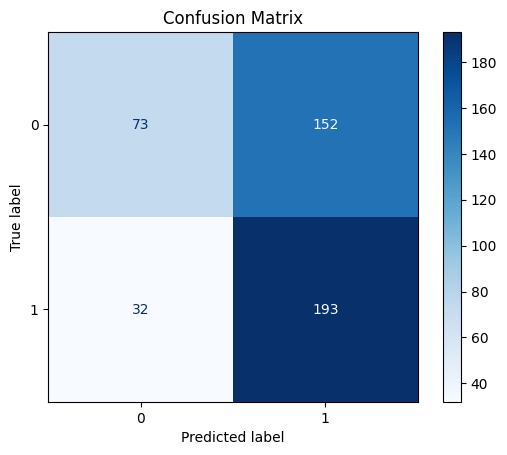

In [41]:
cm = confusion_matrix(test_true_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()